In [ ]:
import os

import torch
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.nn import LGConv
from torch_geometric.utils import to_undirected
from torch_geometric.data import HeteroData
from torch_geometric.nn import LGConv as PygLGConv

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
ratings = pd.read_csv('data/ml-latest-small/ratings.csv')

user_ids, users = pd.factorize(ratings['userId'])
item_ids, items = pd.factorize(ratings['movieId'])

num_users = users.size
num_items = items.size
num_nodes = num_users + num_items

In [6]:
rng = np.random.RandomState(42)

# Train-Test Set Split by Strategy of per-user leave-one-out
positive_edges = {} # All positive edges
for u, i in zip(user_ids, item_ids):
    positive_edges.setdefault(u, set()).add(i)

test_pairs = [] # Test Set
train_user_items = {} # Train Set Raw data
for u, items in positive_edges.items():
    # If number of ratings for one user less than 2
    # Put all of them in trianing set
    if len(items) < 2:
        train_user_items[u] = set(items)
    # Randomly choose one edge as test case for each user
    else:
        items = list(items)
        i_test = rng.choice(items)
        test_pairs.append((u, i_test))
        items.remove(i_test)
        train_user_items[u] = set(items)

In [7]:
# Reconstruct the training graph
train_u, train_i = [], []
for u, S in train_user_items.items():
    for i in S:
        train_u.append(u)
        train_i.append(i)
train_u = np.array(train_u)
train_i = np.array(train_i)

src = torch.tensor(train_u, dtype=torch.long)
dst = torch.tensor(train_i + num_users, dtype=torch.long)
edge_index = torch.stack([src, dst], dim=0) # Each column represents an edge
# Add reverse edges
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1).to(device)

train_set = {u: set() for u in range(num_users)} # Train Set
for u, i in zip(train_u, train_i):
    train_set[u].add(i)

In [8]:
# Negative Sampling
# Return batch of positive samples ui and negative samples uj
def sample_triples(batch_size, train_set):
    us, is_, js = [], [], []
    users = [u for u in range(num_users) if len(train_set[u]) > 0]
    for _ in range(batch_size):
        # Randomly sample a user u from train set
        u = rng.choice(users)
        # Positive sample for user u
        i = rng.choice(list(train_set[u])) 
        # Negative sample for user u
        j = rng.randint(0, num_items)
        while j in train_set[u]:
            j = rng.randint(0, num_items) 
        us.append(u); is_.append(i); js.append(j)

    us = torch.tensor(us, dtype=torch.long, device=device)
    is_ = torch.tensor(is_, dtype=torch.long, device=device)
    js = torch.tensor(js, dtype=torch.long, device=device)
    return (us, is_, js)

In [ ]:
class LightGCN(nn.Module):
    def __init__(self, num_nodes, emb_dim=64, n_layers=3):
        super().__init__()
        self.num_nodes = num_nodes
        self.emb_dim = emb_dim
        self.n_layers = n_layers

        self.emb = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_uniform_(self.emb.weight)

        self.convs = nn.ModuleList([PygLGConv() for _ in range(n_layers)])

    def forward(self, edge_index):
        # edge_index: [2,E]
        x = self.emb.weight # (N, d)
        outs = [x]

        for conv in self.convs:
            x = conv(x, edge_index)
            outs.append(x)
        return torch.stack(outs, dim=0).mean(dim=0)
    

    def loss(self, user_emb, pos_emb, neg_emb, l2_reg=1e-4):
        pos_scores = (user_emb * pos_emb).sum(dim=1)
        neg_scores = (user_emb * neg_emb).sum(dim=1)
        x = pos_scores - neg_scores
        bpr = F.softplus(-x).mean()

        reg = (user_emb.norm(dim=1).pow(2) +
            pos_emb.norm(dim=1).pow(2) +
            neg_emb.norm(dim=1).pow(2)).mean()
        return bpr + l2_reg * reg

    

    def fit(self, edge_index, num_users, sample_triples, train_set,
            optimizer, epochs=100, batch_size=2048, l2_reg=1e-4, device="cuda"):
        self.to(device)
        total_pos = sum(len(items) for items in train_set.values())
        steps = max(1, total_pos // batch_size)

        loss_history = []

        for epoch in tqdm(range(1, epochs + 1)):
            self.train()
            running = 0.0

            for _ in range(steps):
                all_emb = self.forward(edge_index)
                all_user_list, all_item_list = all_emb[:num_users], all_emb[num_users:]
                u, i, j = sample_triples(batch_size, train_set)
                ue, ie, je = all_user_list[u], all_item_list[i], all_item_list[j]

                loss = self.loss(ue, ie, je, l2_reg=l2_reg)

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

                running += float(loss.detach())
            loss_history.append(running / steps)

        return loss_history
    
    @torch.no_grad()
    def evaluate_full_ranking(
        self,
        edge_index: torch.Tensor,
        train_user_items: dict,
        test_pairs: list,
        num_users: int,
        num_items: int,
        K: int = 10,
    ):
        self.eval()
        edge_index = edge_index.to(device)

        all_emb = self(edge_index)
        user_all, item_all = all_emb[:num_users], all_emb[num_users:]

        hr_hits, ndcg_sum, auc_sum, n_eval = 0, 0.0, 0.0, 0

        for (u, i_pos) in test_pairs:
            u_items = train_user_items.get(u, set())
            
            neg_items = [j for j in range(num_items) if (j not in u_items and j != i_pos)]

            cand_items = torch.tensor([i_pos] + neg_items, device=device, dtype=torch.long)

            u_emb = user_all[u].unsqueeze(0)
            i_emb = item_all[cand_items]
            scores = (u_emb * i_emb).sum(dim=1)

            # HR@K
            topk = min(K, scores.numel())
            topk_idx = torch.topk(scores, k=topk, dim=0).indices
            # 0 is the positive sample
            hit = (topk_idx == 0).any().item()
            if hit:
                hr_hits += 1
                ranks = torch.argsort(scores, descending=True)
                rank_pos = (ranks == 0).nonzero(as_tuple=False).item() + 1
                ndcg_sum += 1.0 / torch.log2(torch.tensor(rank_pos + 1.0, device=device)).item()

            # AUC：P(score_pos > score_neg)
            if scores.numel() > 1:
                auc = (scores[0] > scores[1:]).float().mean().item()
                auc_sum += auc

            n_eval += 1

        metrics = {
            "HR@K": hr_hits / max(1, n_eval),
            "NDCG@K": ndcg_sum / max(1, n_eval),
            "AUC": auc_sum / max(1, n_eval),
            "UsersEvaluated": n_eval,
        }
        return metrics

In [10]:
model = LightGCN(num_nodes, emb_dim=64, n_layers=3).to(device)
opt = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=0)

In [11]:
epochs = 100

loss_history = model.fit(edge_index=edge_index, num_users=num_users, sample_triples=sample_triples,
                        train_set=train_set, optimizer=opt, epochs=epochs)

100%|██████████| 100/100 [06:12<00:00,  3.72s/it]


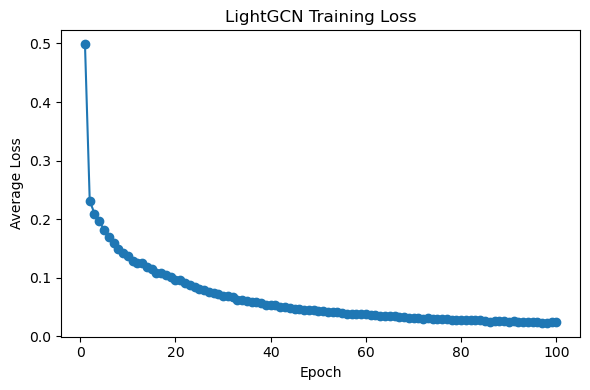

In [12]:
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.title("LightGCN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.tight_layout()
plt.show()


In [14]:
metrics = model.evaluate_full_ranking(
    edge_index=edge_index,
    train_user_items=train_user_items,
    test_pairs=test_pairs,
    num_users=num_users,
    num_items=num_items,
    K=10
)
print(metrics)


{'HR@K': 0.19672131147540983, 'NDCG@K': 0.10368992404843941, 'AUC': 0.9359184732721721, 'UsersEvaluated': 610}
